Imports

In [706]:
import pandas as pd
import numpy as np
from pyomo.environ import * 
from pyomo.opt import SolverFactory
import folium
import csv
import random  
import copy
from collections import Counter

Cargar archivos requerido por la instancia

In [707]:
clients_df = pd.read_csv("Proyecto_A_Caso2/clients.csv")
depots_df = pd.read_csv("Proyecto_Caso_Base/depots.csv")
vehicles_df = pd.read_csv("Proyecto_A_Caso2/vehicles.csv")


In [708]:
print(clients_df)
print(depots_df)
print(vehicles_df)
capacidad_maxima = vehicles_df['Capacity'].max()

vehicles_df['Capacity'] = capacidad_maxima

   ClientID  LocationID  Demand  Longitude  Latitude
0         1          13      12 -74.196992  4.632553
1         2          14      15 -74.155037  4.601328
2         3          15      15 -74.101787  4.732421
3         4          16       6 -74.194862  4.638612
4         5          17       5 -74.110272  4.727692
5         6          18      11 -74.152289  4.665003
6         7          19      12 -74.032411  4.677102
7         8          20      10 -74.062476  4.707007
8         9          21      15 -74.098042  4.636075
   LocationID  DepotID  Longitude  Latitude  Capacity
0           1        1 -74.153536  4.743359        90
  VehicleType    Capacity        Range
0     Gas Car  131.921140   145.852071
1          EV  108.435620  1304.605971
2          EV   91.504255   953.172609
3       drone   32.896064    17.302304
4       drone   22.652628    16.627680
5       drone   22.682912    13.602811


In [709]:
C=list(depots_df["DepotID"])
CAP=dict(zip(depots_df["DepotID"],depots_df["Capacity"]))

In [710]:
print("Conjunto C:", C)
print("Capacidades CAP_i:", CAP)

Conjunto C: [1]
Capacidades CAP_i: {1: 90}


In [711]:
K=list(clients_df["ClientID"])
DEM=dict(zip(clients_df["ClientID"],clients_df["Demand"])) 
COORDENADAS_CLIENTES=dict(zip(clients_df["ClientID"],zip(clients_df["Longitude"],clients_df["Latitude"])))

In [712]:
print("Conjunto K: clientes", K)
print("Capacidades Demanda:", DEM)
print("Coordenadas clientes:", COORDENADAS_CLIENTES)

Conjunto K: clientes [1, 2, 3, 4, 5, 6, 7, 8, 9]
Capacidades Demanda: {1: 12, 2: 15, 3: 15, 4: 6, 5: 5, 6: 11, 7: 12, 8: 10, 9: 15}
Coordenadas clientes: {1: (-74.19699184741948, 4.632552840424734), 2: (-74.15503659129905, 4.601328214582278), 3: (-74.10178731827096, 4.732421040989568), 4: (-74.19486224157397, 4.638612189685843), 5: (-74.11027242131048, 4.727691608175209), 6: (-74.15228946899238, 4.665002925306577), 7: (-74.03241075805882, 4.6771016997028205), 8: (-74.0624758742746, 4.707007012114083), 9: (-74.09804168568287, 4.636074548012315)}


Distancia harvesiana

In [713]:
def dist_haversiana(lon1,lat1,lon2,lat2):
  R=6371.0 #radio tierra
  lon1,lat1,lon2,lat2=map(np.radians,[lon1,lat1,lon2,lat2])
  dlon=lon2-lon1
  dlat=lat2-lat1
  a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
  c = 2 * np.arcsin(np.sqrt(a))
  return R * c

In [714]:
DIST={}
for i,depot in depots_df.iterrows():
  for j,client in clients_df.iterrows():
    di=depot["DepotID"]
    ci=client["ClientID"]
    distance=dist_haversiana(depot["Longitude"],depot["Latitude"],
                             client["Longitude"],client["Latitude"]
                             )
    DIST[(di,ci)]=round(distance,2)

In [715]:
for key, val in list(DIST.items())[:5]:
  print("La distancia entre el centro de distribucion", key[0], "y el cliente", key[1], "es de", val)

La distancia entre el centro de distribucion 1.0 y el cliente 1.0 es de 13.23
La distancia entre el centro de distribucion 1.0 y el cliente 2.0 es de 15.79
La distancia entre el centro de distribucion 1.0 y el cliente 3.0 es de 5.86
La distancia entre el centro de distribucion 1.0 y el cliente 4.0 es de 12.52
La distancia entre el centro de distribucion 1.0 y el cliente 5.0 es de 5.1


In [716]:
V=list(vehicles_df.index)
Q = dict(zip(V, vehicles_df["Capacity"]))


R = dict(zip(V, vehicles_df["Range"]))

In [717]:
print("Vehículos:", V)
print("Capacidades:", Q)
print("Rangos:", R)

Vehículos: [0, 1, 2, 3, 4, 5]
Capacidades: {0: 131.9211396722696, 1: 131.9211396722696, 2: 131.9211396722696, 3: 131.9211396722696, 4: 131.9211396722696, 5: 131.9211396722696}
Rangos: {0: 145.85207096486445, 1: 1304.605971281605, 2: 953.172608610164, 3: 17.302304187458727, 4: 16.627680130757895, 5: 13.602810739289229}


In [718]:
for v in V:
    print(f"vehiculo {v}: Tipo={vehicles_df['VehicleType'][v]}, Capacidad={Q[v]}, Rango={R[v]}")

vehiculo 0: Tipo=Gas Car, Capacidad=131.9211396722696, Rango=145.85207096486445
vehiculo 1: Tipo=EV, Capacidad=131.9211396722696, Rango=1304.605971281605
vehiculo 2: Tipo=EV, Capacidad=131.9211396722696, Rango=953.172608610164
vehiculo 3: Tipo=drone, Capacidad=131.9211396722696, Rango=17.302304187458727
vehiculo 4: Tipo=drone, Capacidad=131.9211396722696, Rango=16.627680130757895
vehiculo 5: Tipo=drone, Capacidad=131.9211396722696, Rango=13.602810739289229


Implementar metodo metaheurístico: Algorimo genético 

Parametros

In [719]:
pupulation_size = 120
max_generations = 200
crossover_rate = 0.6
mutation_rate = 0.4
elitism_count = 4

Inicialización de la población

La población es el conjunto de individuos que representan posibles soluciones. En este caso un individuo representa una forma distinta de asignar clientes a vehículos, definir el orden de visita de esos clientes por vehículo y respetar la capacidad del vehículo.

In [ ]:
def repair_individual(individual, all_clients, capacities, demands):
    """

    Revisar que todos los clientes son visitados exactamenteuna vez y se atienden las capacidades

    """

    # Step 1: Identify missing and duplicated clients
    visited_clients = set()
    duplicated_clients = []
    current_clients_in_routes = []

    # Flatten the individual to process all clients currently in routes
    for route in individual:
        for client in route:
            if client in visited_clients:
                duplicated_clients.append(client)
            else:
                visited_clients.add(client)
            current_clients_in_routes.append(client) # Keep track of clients as they appear

    missing_clients = [c for c in all_clients if c not in visited_clients]

    # Step 2: Remove duplicates and add missing clients
    # Create a new, clean set of routes, ensuring no duplicates within the same route first
    repaired_individual = []
    for route in individual:
        cleaned_route = []
        seen_in_route = set()
        for client in route:
            if client not in seen_in_route:
                cleaned_route.append(client)
                seen_in_route.add(client)
        if cleaned_route: # Only add non-empty routes
            repaired_individual.append(cleaned_route)

    final_repaired_individual = []
    global_seen = set()
    for route in repaired_individual:
        new_route = []
        for client in route:
            if client not in global_seen:
                new_route.append(client)
                global_seen.add(client)
            else:
                missing_clients.append(client)
        if new_route:
            final_repaired_individual.append(new_route)
    repaired_individual = final_repaired_individual


    for client_to_add in missing_clients:
        added = False
        # Try to add to an existing route without exceeding capacity
        for idx, route in enumerate(repaired_individual):
            # Use min(idx, len(capacities)-1) to safely access capacities
            vehicle_capacity = capacities[min(idx, len(capacities) - 1)]
            current_load = sum(demands[c] for c in route)
            if current_load + demands[client_to_add] <= vehicle_capacity:
                route.append(client_to_add)
                added = True
                break
        if not added:
            # If no existing route can take it, create a new route for the client
            # This implicitly assumes we have enough vehicles.
            repaired_individual.append([client_to_add])


    for _ in range(5): # Iterate a few times to try and balance
        for idx, route in enumerate(repaired_individual):
            vehicle_capacity = capacities[min(idx, len(capacities) - 1)]
            current_load = sum(demands[c] for c in route)

            if current_load > vehicle_capacity:
                # Try to move clients from this overloaded route to other routes
                # Sort clients by demand in descending order to move largest ones first
                clients_in_route = sorted(route, key=lambda c: demands[c], reverse=True)
                for client_to_move in clients_in_route:
                    if current_load - demands[client_to_move] >= 0: # Ensure we don't go negative
                        moved = False
                        # Try to move to another existing route
                        for target_idx, target_route in enumerate(repaired_individual):
                            if idx != target_idx: # Don't move to the same route
                                target_capacity = capacities[min(target_idx, len(capacities) - 1)]
                                target_load = sum(demands[c] for c in target_route)
                                if target_load + demands[client_to_move] <= target_capacity:
                                    target_route.append(client_to_move)
                                    route.remove(client_to_move)
                                    current_load -= demands[client_to_move]
                                    moved = True
                                    break
                        if moved:
                            break # Move one client at a time and re-evaluate

    # Ensure all routes are non-empty after all operations
    repaired_individual = [route for route in repaired_individual if route]


    # Final check: Ensure all original clients are still present (no accidental loss)
    final_clients = set(sum(repaired_individual, []))
    if len(final_clients) != len(all_clients) or not all(c in final_clients for c in all_clients):
        # Fallback if something went wrong: reconstruct from all_clients
        # This is a defensive measure and ideally should not be hit.
        temp_individual = []
        remaining_clients = list(all_clients)
        random.shuffle(remaining_clients)
        route_idx = 0
        while remaining_clients and route_idx < len(capacities):
            current_route = []
            current_load = 0
            while remaining_clients:
                next_client = remaining_clients[0]
                if current_load + demands[next_client] <= capacities[route_idx]:
                    current_route.append(remaining_clients.pop(0))
                    current_load += demands[next_client]
                else:
                    break
            if current_route:
                temp_individual.append(current_route)
            route_idx += 1
        if remaining_clients: # If clients are still left, add them to new routes
            for client in remaining_clients:
                temp_individual.append([client])
        repaired_individual = temp_individual


    return repaired_individual



def inicializar_poblacion(poblacion_size, clients, cap_vehiculos, dem_clients):
    poblacion = []
    for _ in range(poblacion_size):
        clientes_barajados = clients.copy()
        np.random.shuffle(clientes_barajados)

        individuo = []
        ruta_actual = []
        carga_actual = 0
        capacidad_idx = 0

        for cliente in clientes_barajados:
            demanda = dem_clients[cliente]
            if carga_actual + demanda <= cap_vehiculos[capacidad_idx]:
                ruta_actual.append(cliente)
                carga_actual += demanda
            else:
                individuo.append(ruta_actual)
                capacidad_idx += 1
                if capacidad_idx >= len(cap_vehiculos):
                    break
                ruta_actual = [cliente]
                carga_actual = demanda

        if ruta_actual:
            individuo.append(ruta_actual)

        poblacion.append(individuo)
    return poblacion

def fitness(individual, distancias, deposito_id, coords_clientes, cap_vehiculos, dem_clients, clients, rango_vehiculos):
    costo_total = 0
    penalizacion = 0
    Pf = 123.12  # COP/km (combustible)
    Ft = 823     # COP/km (flete)
    Cm = 700     # COP/km (mantenimiento)

    # Validar que cada cliente es visitado exactamente una vez
    # y que no se repiten de lo contrario se penaliza
    clientes_visitados = sum(individual, [])  # aplanar rutas
    conteo = Counter(clientes_visitados)

    for c in clients:
        if conteo[c] != 1: 
            penalizacion += 1000 * abs(conteo[c] - 1)

    # Recorrer cada ruta (vehículo)
    for idx, ruta in enumerate(individual):
        if not ruta:
            continue

        # Restricción de capacidad del vehículo
        carga = sum(dem_clients[c] for c in ruta)
        if carga > cap_vehiculos[min(idx, len(cap_vehiculos)-1)]:
            penalizacion += 1000 * (carga - cap_vehiculos[min(idx, len(cap_vehiculos)-1)])

        # Calcular la distancia total de esta ruta
        distancia_total = 0
        distancia_total += distancias[(deposito_id, ruta[0])]  

        for i in range(len(ruta) - 1):
            c1, c2 = ruta[i], ruta[i+1]
            lon1, lat1 = coords_clientes[c1]
            lon2, lat2 = coords_clientes[c2]
            distancia_total += dist_haversiana(lon1, lat1, lon2, lat2)

        distancia_total += distancias[(deposito_id, ruta[-1])] 

        costo_total += distancia_total

        # Restriccion para que no se exceda el rango 
        # permitido
        if distancia_total > rango_vehiculos[min(idx, len(rango_vehiculos)-1)]:
            penalizacion += 1000 * (distancia_total - rango_vehiculos[min(idx, len(rango_vehiculos)-1)])
    
    costo_total *= (Pf + Ft + Cm)  


    return costo_total + penalizacion, costo_total, penalizacion


def seleccion_torneo(population, fitness_scores, k=2):
    selected = []
    for _ in range(len(population)):
        indices = random.sample(range(len(population)), k)
        mejor_idx = min(indices, key=lambda i: fitness_scores[i])
        selected.append(copy.deepcopy(population[mejor_idx]))
    return selected

def crossover_rutas(p1, p2):
    hijo1, hijo2 = [], []

    split1 = random.randint(0, len(p1)-1)
    split2 = random.randint(0, len(p2)-1)

    r1 = p1[:split1]
    r2 = p2[split2:]

    flat_r1 = set(sum(r1, []))
    flat_r2 = set(sum(r2, []))

    restantes1 = [c for ruta in p2 for c in ruta if c not in flat_r1]
    restantes2 = [c for ruta in p1 for c in ruta if c not in flat_r2]

    hijo1 = r1 + [restantes1]
    hijo2 = r2 + [restantes2]

    return hijo1, hijo2

def mutar_individuo(individual):
    rutas_validas = [ruta for ruta in individual if len(ruta) >= 1]
    if len(rutas_validas) < 2:
        return

    r1, r2 = random.sample(rutas_validas, 2)
    i1 = random.randint(0, len(r1) - 1)
    i2 = random.randint(0, len(r2) - 1)
    r1[i1], r2[i2] = r2[i2], r1[i1]



# K clientes 
# Q capacidades de los vehiculos
# DEM demanda de los clientes
cap_vehiculos_transform = [Q[v] for v in V] 
population = inicializar_poblacion(pupulation_size, K, cap_vehiculos_transform, DEM)


# print("K",K)
print("CAP",cap_vehiculos_transform)
print("DEM",DEM)
print("cap vehiculos",)
# print("Dist: ", DIST)
# print("Distancia cliente: " , COORDENADAS_CLIENTES)

# for i, individuo in enumerate(population):
#     clientes_visitados = sum(individuo, [])  # Flatten all rutas
#     if len(clientes_visitados) != len(set(clientes_visitados)):
#         print(f"Individuo {i} tiene clientes repetidos")
#     else:
#         print(f"Individuo {i} es válido ")

DIST_correctos_ids = {(int(i), int(j)): float(d) for (i, j), d in DIST.items()}
rango_vehiculos = [R[v] for v in V]  # igual que cap_vehiculos
print("Rango vehiculos: ", rango_vehiculos)

print("Debug inicial:")
for i, ind in enumerate(population[:5]):
    fit, costo, penal = fitness(ind, DIST_correctos_ids, 1, COORDENADAS_CLIENTES, cap_vehiculos_transform, DEM, clients_df["ClientID"].tolist(), rango_vehiculos)
    print(f"Ind {i}: fitness total = {fit}, costo real = {costo}, penalización = {penal}")

# Evaluar la población inicial
fitness_scores = [
    fitness(ind, DIST_correctos_ids, 1, COORDENADAS_CLIENTES, cap_vehiculos_transform, DEM, clients_df["ClientID"].tolist(), rango_vehiculos)
    for ind in population
]

# print("Poblacion inicial: ", population)
# print("Fitness scores: ", fitness_scores)

mejores_por_generacion = []

for generation in range(max_generations):
    # Selección
    mating_pool = seleccion_torneo(population, fitness_scores)

    # Cruce
    offspring = []
    for _ in range((pupulation_size - elitism_count) // 2):
        p1, p2 = random.sample(mating_pool, 2)
        if random.random() < crossover_rate:
            h1, h2 = crossover_rutas(p1, p2)
        else:
            h1, h2 = p1.copy(), p2.copy()
        h1_repaired = repair_individual(h1, K, cap_vehiculos_transform, DEM)
        h2_repaired = repair_individual(h2, K, cap_vehiculos_transform, DEM)
        offspring.extend([h1_repaired, h2_repaired])

    # Mutación
    for idx in range(len(offspring)):
        if random.random() < mutation_rate:
            mutar_individuo(offspring[idx])
            # Repara el individuo después de la mutación
            offspring[idx] = repair_individual(offspring[i], K, cap_vehiculos_transform, DEM)

    # Evaluar descendencia
    # Evaluar descendencia
    offspring_fitness = [
        fitness(ind, DIST_correctos_ids, 1, COORDENADAS_CLIENTES, cap_vehiculos_transform, DEM, clients_df["ClientID"].tolist(), rango_vehiculos)
        for ind in offspring
    ]

    # Elitismo sobre población actual
    elite_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i])[:elitism_count]
    elites = [copy.deepcopy(population[i]) for i in elite_indices]
    elite_fitness = [fitness_scores[i] for i in elite_indices]

    # Nueva población y sus fitness
    population = elites + offspring[:pupulation_size - elitism_count]
    fitness_scores = elite_fitness + offspring_fitness[:pupulation_size - elitism_count]
    mejores_por_generacion.append(min(fitness_scores))

    

    # (Opcional) Registrar mejor fitness por generación

CAP [131.9211396722696, 131.9211396722696, 131.9211396722696, 131.9211396722696, 131.9211396722696, 131.9211396722696]
DEM {1: 12, 2: 15, 3: 15, 4: 6, 5: 5, 6: 11, 7: 12, 8: 10, 9: 15}
cap vehiculos
Rango vehiculos:  [145.85207096486445, 1304.605971281605, 953.172608610164, 17.302304187458727, 16.627680130757895, 13.602810739289229]
Debug inicial:


NameError: name 'fit' is not defined

In [ ]:
# Encontrar el mejor individuo después de todas las generaciones
mejor_idx = fitness_scores.index(min(fitness_scores))
mejor_individuo = population[mejor_idx]
mejor_costo = fitness_scores[mejor_idx]

print("\n Mejor solución encontrada:")
print("Costo total:", round(mejor_costo, 2))
print("Rutas asignadas:")
for i, ruta in enumerate(mejor_individuo):
    print(f"  Vehículo {i+1}: {ruta}")


 Mejor solución encontrada:
Costo total: 121837.67
Rutas asignadas:
  Vehículo 1: [4, 6, 3, 5, 8, 7, 9, 2, 1]


In [ ]:
import folium

# Encontrar el mejor individuo
mejor_idx = fitness_scores.index(min(fitness_scores))
mejor_individuo = population[mejor_idx]

# Crear el mapa centrado en Bogotá
mapa = folium.Map(location=[4.60971, -74.08175], zoom_start=12)

# Marcar el depósito (usando solo uno para este caso)
for _, depot in depots_df.iterrows():
    folium.Marker(
        location=[depot['Latitude'], depot['Longitude']], 
        popup=f"CD {depot['DepotID']}", 
        icon=folium.Icon(color='blue')
    ).add_to(mapa)

# Marcar todos los clientes
for _, client in clients_df.iterrows():
    folium.Marker(
        location=[client['Latitude'], client['Longitude']], 
        popup=f"Cliente {client['ClientID']}",
        icon=folium.Icon(color='green')
    ).add_to(mapa)

# Dibujar rutas del mejor individuo
for ruta in mejor_individuo:
    if not ruta:
        continue
    ruta_coords = []

    # Punto de inicio (depósito)
    cd_lat = depots_df.iloc[0]['Latitude']
    cd_lon = depots_df.iloc[0]['Longitude']
    ruta_coords.append([cd_lat, cd_lon])

    # Coordenadas de clientes en la ruta
    for cliente_id in ruta:
        client_lat, client_lon = COORDENADAS_CLIENTES[cliente_id][1], COORDENADAS_CLIENTES[cliente_id][0]
        ruta_coords.append([client_lat, client_lon])

    # Retorno al depósito
    ruta_coords.append([cd_lat, cd_lon])

    folium.PolyLine(ruta_coords, color='red', weight=2.5, opacity=1).add_to(mapa)

# Guardar el resultado
mapa.save("mejor_ruta.html")


In [ ]:
import folium

mapa = folium.Map(location=[4.6, -74.1], zoom_start=12)
colors = ["red", "blue", "green", "orange", "purple", "darkred", "cadetblue", "gray"]

for i, ruta in enumerate(mejor_individuo):
    coords = [[COORDENADAS_CLIENTES[c][1], COORDENADAS_CLIENTES[c][0]] for c in ruta]
    coords.insert(0, [depots_df.iloc[0]["Latitude"], depots_df.iloc[0]["Longitude"]])  # desde depósito
    coords.append([depots_df.iloc[0]["Latitude"], depots_df.iloc[0]["Longitude"]])     # regreso

    folium.PolyLine(coords, color=colors[i % len(colors)], weight=3).add_to(mapa)

mapa.save("mejor_rutaOtraAlternativa.html")


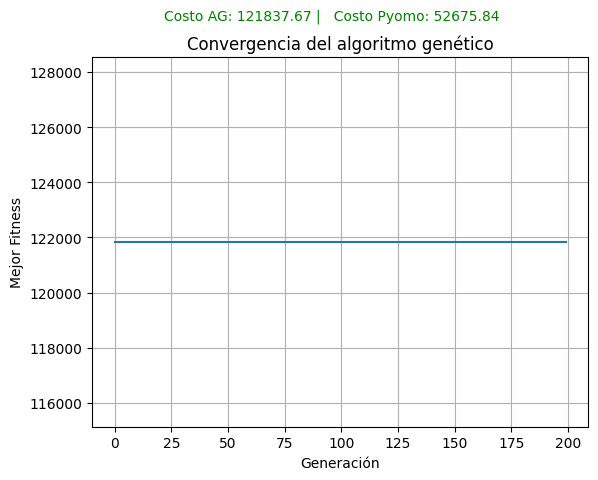

In [ ]:

import matplotlib.pyplot as plt

plt.plot(mejores_por_generacion)
plt.title("Convergencia del algoritmo genético")
plt.xlabel("Generación")
plt.ylabel("Mejor Fitness")
plt.grid(True)
plt.suptitle(f"Costo AG: {mejor_costo:.2f} |   Costo Pyomo: 52675.84", fontsize=10, color="green")
plt.savefig("convergencia_AG_Proyecto_Prueba.png")
plt.show()


Evaluación

Selección

Cruce(recombinación)

Mutación

Reemplazo

Iteración